In [1]:
import os, sys, pathlib, importlib
sys.path.append('../')

# Load the package and modules for training and plotting
import nsbi_common_utils
from nsbi_common_utils import plotting, training
from nsbi_common_utils.training import TrainEvaluate_NN, TrainEvaluatePreselNN


import tensorflow as tf
tf.config.optimizer.set_jit(False)
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Nadam
import mplhep as hep
import matplotlib.pyplot as plt
import pickle
import yaml
import random

from utils import preselection_using_score, calculate_preselection_observable

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

hep.style.use(hep.style.ATLAS)

/home/jsandesara_umass_edu/.conda/envs/nsbi_env/lib/python3.9/site-packages/nsbi_common_utils/plotting.py:11: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style("ATLAS")
2025-08-09 08:11:27.962488: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-09 08:11:27.975229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-09 08:11:27.987075: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-09 08:11:27.990936: E exte

In [2]:
with open("config.yml", "r") as f:
    config = yaml.safe_load(f)

In [3]:
PATH_PREFIX = config["PATH_PREFIX"]
PATH_TO_SAVED_DATA = config["PATH_SAVED_DATA"]

PATH_PRESEL_MODEL = PATH_TO_SAVED_DATA + 'preselection_model/'

config.update(
    {
        "PATH_PRESEL_MODEL": PATH_PRESEL_MODEL
    }
)

In [4]:
# Get the dictionary of labels to processes
labels_dict = config["PROCESS_TO_INT_LABELS_DICT"]

# Signal processes in the model
signal_processes = config["SIGNAL_PROCESSES"]

# Background processes in the model
background_processes = config["BACKGROUND_PROCESSES"]

print(signal_processes)
print(background_processes)

['htautau']
['ttbar', 'ztautau']


In [5]:
# If the preselection NN has already been trained and saved, load from the saved model
USE_SAVED_MODEL_PRESEL = False

# If the preselection NN has already been trained and evaluated, load the numpy array of predictions
USE_SAVED_PRESEL_PREDICTIONS = False

# Input features for training
features = config["TRAINING_FEATURES"]

# Subset of the features to standardize before training
features_scaling = config["TRAINING_FEATURES_TO_SCALE"]


In [6]:
# Load the nominal dataset saved from the pre-processing notebook

path_to_nominal_dataframe = config["PATH_TO_nominal_DATA"]
dataset_incl_nominal = pd.read_hdf(path_to_nominal_dataframe, key="dataset", mode='r')

In [7]:
# Load the MC/data weights and training labels identifying different processes
weights         = dataset_incl_nominal["weights"].to_numpy()
train_labels    = dataset_incl_nominal["train_labels"].to_numpy()

In [8]:
# Normalizing the training weights - only discriminating shapes
weights_normed  = weights.copy()

for key in labels_dict:

    weights_normed[train_labels==labels_dict[key]] /= weights[train_labels==labels_dict[key]].sum()

dataset_incl_nominal['weights_normed'] = weights_normed


Training the Preselection NN
===

**Choice of reference sample**

The density ratios need to be trained on phase space regions with support for the reference hypothesis $p_{ref}(x) > 0$.

To ensure this, we make a selection that selects events in the phase space regions with $p_{ref}(x) > 0$, or $p_c(x) \gg p_{ref}(x)$, and only perform the NSBI fit in this selected analysis region. **A natural choice for the reference hypothesis is then the signal-rich hypotheses**. This is referred to in the ATLAS publications as the Search-Oriented Mixture Models approach: 

$$p_{ref}(x) = \frac{1}{\sum_S \nu_S} \sum_S \frac{d\sigma_S}{dx} = \frac{1}{\nu_{H \to \tau\tau}} \frac{d\sigma_{H \to \tau\tau}}{dx}$$

where the sum runs over all signal hypothesis in the model and the second equality is due to the sole signal hypothesis in our toy model, $pp \to {t\bar{t}}$. 

In [9]:
# What are the signal processes in the user-provided model?
print(signal_processes)

['htautau']


In [10]:
# The reference hypothesis is chosen as the sum of signal hypothesis
ref_processes = config["REFERENCE_PROCESSES"]
print(ref_processes)

['htautau', 'ttbar']


**Selecting out regions with $p_{ref}\sim 0$**

A multi-class classification NN, with softmax output, is trained to output a score:

$$ \text{NN}_\text{presel} = \log \left[\frac{\sum_S P_S (x)}{\sum_B P_B(x)} \right]$$

where $P_c$ are the probability scores outputted from the softmax layer of the trained NN.



In [11]:
importlib.reload(sys.modules['nsbi_common_utils.training'])
from nsbi_common_utils.training import TrainEvaluatePreselNN

num_classes = len(labels_dict)

preselectionTraining = TrainEvaluatePreselNN(dataset_incl_nominal, 
                                            num_classes, 
                                            features, 
                                            features_scaling)

In [12]:
if USE_SAVED_PRESEL_PREDICTIONS:

    pred_NN_incl = np.load(f"{PATH_TO_SAVED_DATA}pred_NN_incl.npy")
    presel_score = calculate_preselection_observable(pred_NN_incl, 
                                                     labels_dict, 
                                                     signal_processes, 
                                                     background_processes, 
                                                     pre_factor_dict = pre_factor_preselection_score)

else:
    if not USE_SAVED_MODEL_PRESEL:
        preselectionTraining.train(test_size=0.2, 
                                   random_state=42, 
                                   path_to_save=PATH_PRESEL_MODEL,
                                  batch_size=4096,
                                  epochs=50, learning_rate=0.1)
    
    else:
        preselectionTraining.get_trained_model(PATH_PRESEL_MODEL)

    # Get predictions (softmax outputs)
    pred_NN_incl = preselectionTraining.predict(dataset_incl_nominal)

    presel_score = calculate_preselection_observable(pred_NN_incl, 
                                                     labels_dict, 
                                                     signal_processes, 
                                                     background_processes, 
                                                     pre_factor_dict = {'htautau': 1.0, 'ttbar': 1.0, 'ztautau': 1.0})

    np.save(f"{PATH_TO_SAVED_DATA}presel_score.npy", presel_score)
    np.save(f"{PATH_TO_SAVED_DATA}pred_NN_incl.npy", pred_NN_incl)

2025-08-09 08:11:38.783940: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13377 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:06:00.0, compute capability: 8.6


Epoch 1/50


2025-08-09 08:11:40.439435: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-09 08:11:40.489312: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 91100


880/880 - 9s - 10ms/step - accuracy: 0.7781 - loss: 3.5008e-07 - val_accuracy: 0.7901 - val_loss: 3.3569e-07 - learning_rate: 0.1000
Epoch 2/50
880/880 - 6s - 7ms/step - accuracy: 0.7955 - loss: 3.2784e-07 - val_accuracy: 0.8002 - val_loss: 3.2055e-07 - learning_rate: 0.1000
Epoch 3/50
880/880 - 6s - 7ms/step - accuracy: 0.8034 - loss: 3.1618e-07 - val_accuracy: 0.8054 - val_loss: 3.1287e-07 - learning_rate: 0.1000
Epoch 4/50
880/880 - 6s - 7ms/step - accuracy: 0.8069 - loss: 3.1083e-07 - val_accuracy: 0.8071 - val_loss: 3.0922e-07 - learning_rate: 0.1000
Epoch 5/50
880/880 - 6s - 7ms/step - accuracy: 0.8085 - loss: 3.0782e-07 - val_accuracy: 0.8084 - val_loss: 3.0722e-07 - learning_rate: 0.1000
Epoch 6/50
880/880 - 6s - 7ms/step - accuracy: 0.8098 - loss: 3.0564e-07 - val_accuracy: 0.8102 - val_loss: 3.0461e-07 - learning_rate: 0.1000
Epoch 7/50
880/880 - 6s - 7ms/step - accuracy: 0.8112 - loss: 3.0358e-07 - val_accuracy: 0.8115 - val_loss: 3.0264e-07 - learning_rate: 0.1000
Epoch 8/5

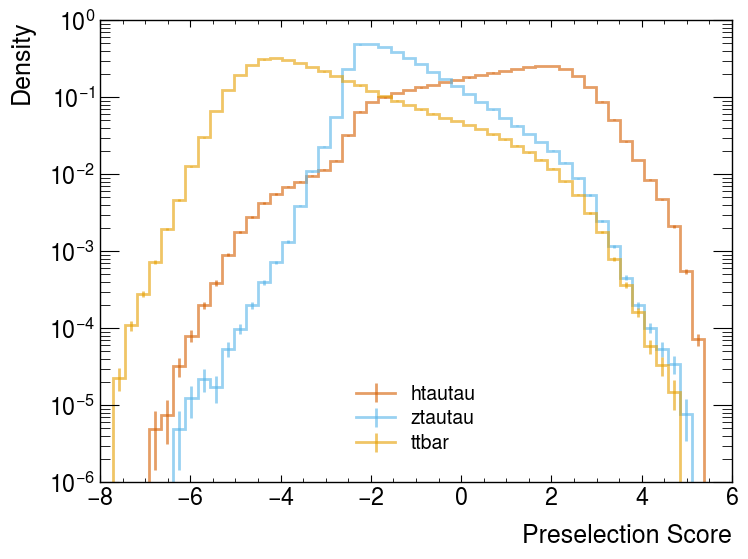

In [13]:
min_pred = np.amin(presel_score)
max_pred = np.amax(presel_score)

bins = np.linspace(min_pred, max_pred, num=50)

hist_NN_output = {}
hist_NN_output_errs = {}

for key in labels_dict: 
    hist_NN_output[key], _ = np.histogram(presel_score[train_labels==labels_dict[key]], 
                                          weights = weights[train_labels==labels_dict[key]], bins=bins)
    
    hist_NN_output_errs[key], _ = np.histogram(presel_score[train_labels==labels_dict[key]], 
                                          weights = weights[train_labels==labels_dict[key]]**2, bins=bins)


for key in labels_dict:  
    hep.histplot(hist_NN_output[key], bins=bins, 
             alpha=0.6, label=key, 
             density=True, linewidth=2.0, yerr = np.sqrt(hist_NN_output_errs[key]))

plt.xlabel("Preselection Score", size=18)
plt.ylabel("Density", size=18)
plt.legend()
plt.yscale('log')
plt.show()

Making the cut
===

Make a selection cut for regions with $p_{ref} \gg 0$ for performing the NSBI analysis. The remaining events - which by definition are background-dominated - can be used as a **Control Region** for data-driven background estimation, pre-unblinding validations, etc. 

Moreover, the preselections act as a tuning know for the tradeoff in selecting as many signal events as possible to go into the **Signal Region** (increasing sensitivity) and the feasibility of training accurate and precise NNs over a large phase space (need bigger models and more statistics). **The preselections can also weed out phase space regions with low background statistics to avoid poorly modelled regions.** 

Heres a first cut that you can optimize as much as you like to get the desired final results. 

In [14]:
dataset_incl_nominal['presel_score'] = presel_score

In [15]:
# Play around with these selections - decrease if estimators are unbiased but need more sensitivity and increase if the model is biased to reduce complexity
preselection_cuts = {'upper': 4.5, 'lower': -1.}
np.save(f"{PATH_TO_SAVED_DATA}preselection_cuts.npy", preselection_cuts)

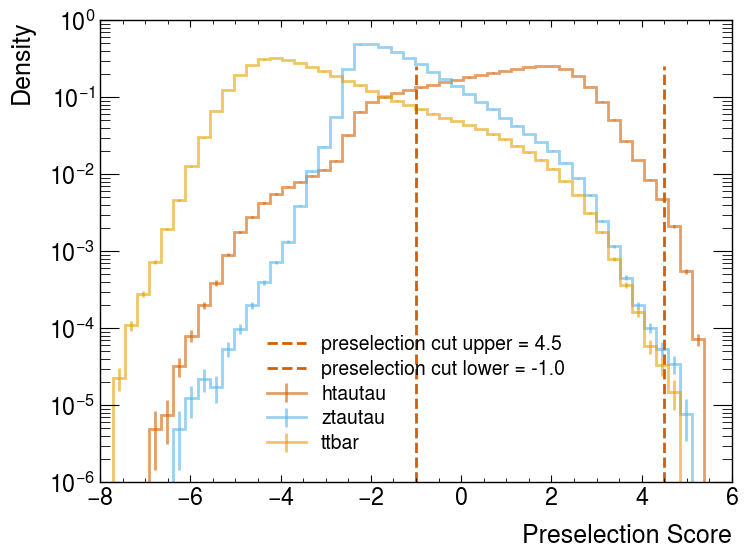

In [17]:
for key in labels_dict:  
    hep.histplot(hist_NN_output[key], bins = bins, 
             alpha = 0.6, label = key, 
             density = True, linewidth = 2.0, 
                 yerr = np.sqrt(hist_NN_output_errs[key]))

plt.xlabel("Preselection Score", size=18)

for key in preselection_cuts:
    if preselection_cuts[key] != -999:
        plt.axvline(preselection_cuts[key], ymax=0.9, linestyle='--', label=f'preselection cut {key} = {preselection_cuts[key]}')

plt.ylabel("Density", size=18)
plt.legend()
plt.yscale('log')
plt.show()

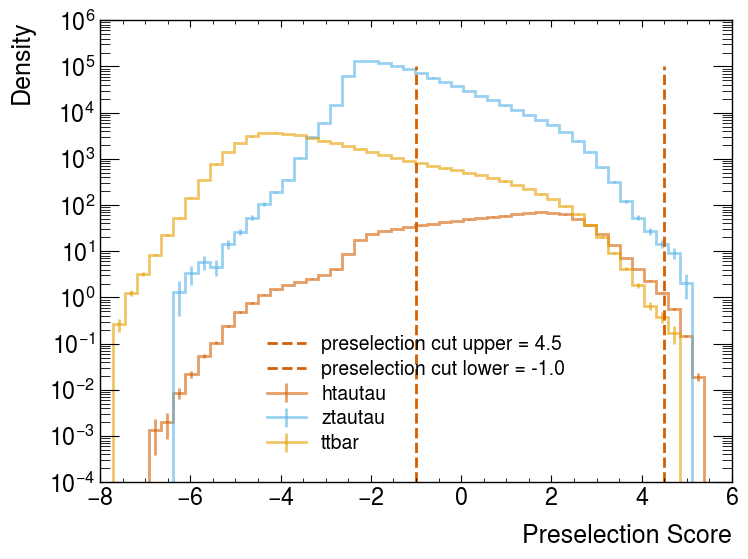

In [18]:
for key in labels_dict:  
    hep.histplot(hist_NN_output[key], bins = bins, 
             alpha = 0.6, label = key, 
             density = False, linewidth = 2.0, 
                 yerr = np.sqrt(hist_NN_output_errs[key]))

plt.xlabel("Preselection Score", size=18)

for key in preselection_cuts:
    if preselection_cuts[key] != -999:
        plt.axvline(preselection_cuts[key], ymax=0.9, linestyle='--', label=f'preselection cut {key} = {preselection_cuts[key]}')

plt.ylabel("Density", size=18)
plt.legend()
plt.yscale('log')
plt.show()

Signal and Control Regions
===

The high signal over background phase space towards the right of the preselection cut shown above will be categorized as the **Signal Region** where the NSBI analysis is performed.

The low signal phase space towards the left will be used as a **Control Region**, with typical uses such as background estimation, pre-unblinding data-MC checks, etc. In this phase space, we will use a binned summary observable like in any traditional analysis.

In [20]:
importlib.reload(sys.modules['utils'])
from utils import preselection_using_score

channel_selections = {'CR': {'observable': 'presel_score', 
                             'preselections': f'presel_score<{preselection_cuts.get('lower')}',
                             'num_bins': 4},
                      
                      'SR_binned': {'observable': 'presel_score', 
                                    'preselections': f'presel_score>{preselection_cuts.get('upper')}',
                                    'num_bins': 1},
                      
                      'SR': {'observable': None, 
                             'preselections': f'presel_score>={preselection_cuts.get('lower')} & presel_score<={preselection_cuts.get('upper')}'
                            }}

dataset_channels = preselection_using_score(dataset_incl_nominal, channel_selections)


In [22]:
# Build a summary observable for binned Signal/Control Regions
hist_binned = {}

config.update(
    {
        "Regions": []
    }
)

for channel, dict_observable in channel_selections.items():

    hist_binned[channel] = {}

    fit_observable = dict_observable['observable']

    config.update(
    {
        "Regions": config[""[{
            "Name": channel,
            "Filter": channel_selections[channel]['preselections'],
            "Variable": None,
            "Binning": None
        },]
    }
)

    if fit_observable == None: continue

    kin_variable = dataset_channels[channel][fit_observable].to_numpy()

    min_kin = np.amin(kin_variable)
    max_kin = np.amax(kin_variable)

    num_bin_edges = dict_observable['num_bins'] + 1

    bins = np.linspace(min_kin, max_kin, num = num_bin_edges)

    # Use the high-level preselection NN score as a summary observable for Control Region
    for process in labels_dict:
        dataset_process = dataset_channels[channel][dataset_channels[channel].detailed_labels==process]
        hist_binned[channel][process], bins = np.histogram(np.clip(dataset_process[fit_observable], min_kin, max_kin),
                                    weights = dataset_process['weights'].ravel(),
                                    bins = bins)

    # Save the Control Region observable
    with open(f"{PATH_TO_SAVED_DATA}hist_binned_{channel}.pkl", "wb") as fp:
        pickle.dump(hist_binned[channel], fp)

    np.save(f"{PATH_TO_SAVED_DATA}bins_{channel}.npy", bins)

    del dataset_channels[channel]

In [23]:
hist_binned['SR_binned']['htautau']

array([1.0238822], dtype=float32)

Text(0, 1, 'Density')

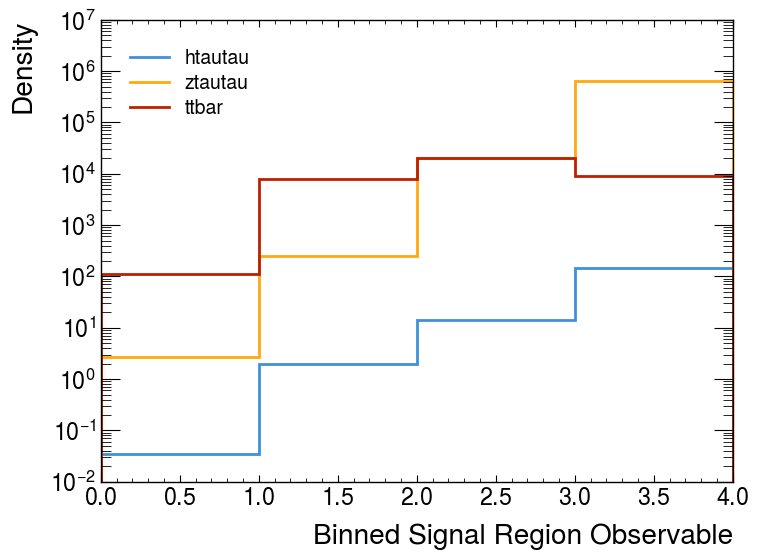

In [21]:
# Plot the Control Region observable

channel = 'CR'

for process in labels_dict:
    
    hep.histplot(hist_binned[channel][process], label=process, linewidth=2.0)

plt.legend()
plt.xlabel('Binned Signal Region Observable')
plt.yscale('log')
plt.ylabel('Density')

Text(0, 1, 'Density')

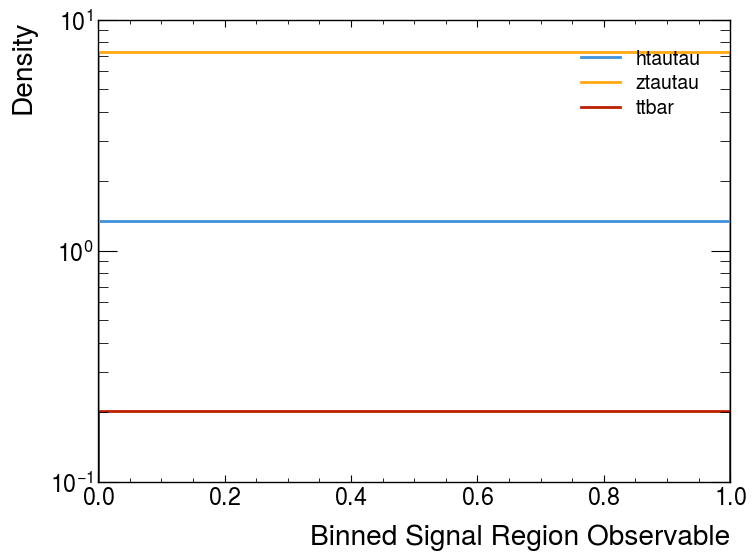

In [22]:
# Plot the Control Region observable

channel = 'SR_binned'

for process in labels_dict:
    
    hep.histplot(hist_binned[channel][process], label=process, linewidth=2.0)

plt.legend()
plt.xlabel('Binned Signal Region Observable')
plt.yscale('log')
plt.ylabel('Density')

In [23]:
dataset = dataset_channels['SR'].copy()

del dataset_channels

In [24]:
# Save the preselected Nominal dataframe for inference use later on
dataset.to_hdf(f"{PATH_TO_SAVED_DATA}dataset_preselected_nominal_SR.h5", key="dataset", mode='w')
